# Download Landsat scenes from Earth Explorer
Author: Conor O'Sullivan 
<br>
Date: 22 May 2023

In [11]:
import pandas as pd
import numpy as np 

import ephem
import math

import matplotlib.pyplot as plt
import seaborn as sns

## Searching for scenes

In [84]:
from landsatxplore.api import API
import os

# Your USGS  credentials
username = os.environ.get('USGS_USERNAME')
password = os.environ.get('USGS_PASSWORD')

# Initialize a new API instance
api = API(username, password)

# Perform a request
response = api.request(endpoint="dataset-catalogs")
print(response)

{'EE': 'EarthExplorer', 'GV': 'GloVis', 'HDDS': 'HDDS Explorer'}


In [2]:
# List of coordinations around Ireland used to search for scenes
coords = [
    (55.2478,-6.1633), 
    (54.8260,-5.6909), 
    (54.4189,-5.4272),
    (54.0529,-5.8557),
    (53.6902,-6.2073),
    (52.9883,-5.9985),
    (52.3353,-6.3171),
    (52.1267,-6.5149),
    (52.0322,-7.5037),
    (51.6657,-8.4155),
    (51.3924,-9.4922),
    (51.5498,-10.2173),
    (52.0390,-10.5798),
    (52.6697,-9.7778),
    (53.1534,-9.3054),
    (53.2981,-10.0415),
    (53.4488,-10.2722),
    (53.8849,-10.0964),
    (54.1045,-10.2612),
    (54.3421,-9.8547),
    (54.2973,-8.8770),
    (54.4828,-8.3716),
    (54.6802,-8.8220),
    (55.0217,-8.5474),
    (55.2979,-7.6575),
    (55.3541,-7.1521),
    (55.1914,-6.7676)]

In [3]:
results = []

# Datasets for Landsat 5, 7, 8 and 9
datasets = ["landsat_tm_c2_l2", "landsat_etm_c2_l2", "landsat_ot_c2_l2"]

for dataset in datasets:
    for lat, lon in coords:
        scenes = api.search(
            
            dataset=dataset,
            latitude=lat,
            longitude=lon,
            start_date='1980-01-01',
            end_date='2023-12-31',
            max_cloud_cover=100,
            max_results=10000
        )
        results.extend(scenes)
    print(dataset, len(results))

landsat_tm_c2_l2 20644
landsat_etm_c2_l2 36458
landsat_ot_c2_l2 50685


In [13]:
# Create a DataFrame from the scenes
df_scenes = pd.DataFrame(results)
print(len(df_scenes))

# Drop duplicates
df_scenes.drop_duplicates(subset=['display_id'], inplace=True)
print(len(df_scenes))

# List of all potential scenes
df_scenes.to_csv('../data/all_scenes.csv', index=False)
df_scenes.head()

50685
14850


,cloud_cover,entity_id,display_id,ordering_id,landsat_product_id,landsat_scene_id,acquisition_date,collection_category,collection_number,sensor_mode,...,gap_phase_source,gap_phase_statistic,scan_gap_interpolation,target_wrs_path,target_wrs_row,nadir-off_nadir,roll_angle,sun_elevation_l0ra,sun_azimuth_l0ra,tirs_ssm_model
0,63,LT52060212011308KIS00,LT05_L2SP_206021_20111104_20200820_02_T2,None,LT05_L1TP_206021_20111104_20200820_02_T2,LT52060212011308KIS00,2011-11-04,2023-05-02,2,BUMPER,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,29,LT52060222011308KIS00,LT05_L2SP_206022_20111104_20200820_02_T2,None,LT05_L1GS_206022_20111104_20200820_02_T2,LT52060222011308KIS00,2011-11-04,2023-05-02,2,BUMPER,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,38,LT52060212011292KIS00,LT05_L2SP_206021_20111019_20200820_02_T1,None,LT05_L1TP_206021_20111019_20200820_02_T1,LT52060212011292KIS00,2011-10-19,2023-05-01,2,BUMPER,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,40,LT52060222011292KIS00,LT05_L2SP_206022_20111019_20200820_02_T2,None,LT05_L1GS_206022_20111019_20200820_02_T2,LT52060222011292KIS00,2011-10-19,2023-05-02,2,BUMPER,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,67,LT52070212011283KIS00,LT05_L2SP_207021_20111010_20200820_02_T1,None,LT05_L1TP_207021_20111010_20200820_02_T1,LT52070212011283KIS00,2011-10-10,2023-05-01,2,BUMPER,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Cleaned scenes dataset and add altitude

In [2]:
def get_altitude(time, lat, lon):
    """Calculate the sun's altitude at
        time: scenes acquisition time
        lat: scenes center latitude
        lon: scenes center longitude"""

    observer = ephem.Observer()
    observer.lat = str(lat)  # Latitude of Dublin, Ireland
    observer.lon = str(lon)  # Longitude of Dublin, Ireland
    
    # Set the date in ephem format
    observer.date = time.strftime("%Y-%m-%d %H:%M:%S.%f")
    
    # Calculate the sun's altitude on the given date
    sun = ephem.Sun()
    sun.compute(observer)
    radians = sun.alt
    altitude = math.degrees(radians)

    return altitude

In [3]:
df_scenes = pd.read_csv('../data/all_scenes.csv')

# Get scene tier 
df_scenes['tier'] = [int(x[-1]) for x in df_scenes["display_id"]]

# Get satellite
df_scenes['satellite'] = [int(str(x)[-1]) for x in df_scenes['satellite']]

# Get necessary columns
df_scenes = df_scenes[['display_id','wrs_path', 'wrs_row','satellite','cloud_cover','tier','utm_zone','scene_center_latitude', 'scene_center_longitude','acquisition_date','start_time']]
df_scenes.columns = ['id','path', 'row','satellite','cloud_cover','tier','utm_zone','lat','lon','date','time']

# Convert date to datetime
df_scenes['time'] = pd.to_datetime(df_scenes['time'])

# Get year and month
df_scenes['year'] = pd.to_datetime(df_scenes['date']).dt.year
df_scenes['month'] = pd.to_datetime(df_scenes['date']).dt.month

# get altitude
df_scenes['altitude'] = df_scenes[['time','lat','lon']].apply(lambda x: get_altitude(*x), axis=1)
df_scenes['altitude_category'] = pd.cut(df_scenes['altitude'], bins=[-90, 30, 50, 90], labels=['low', 'medium', 'high'])

# get tile
df_scenes['tile'] = df_scenes['path'].astype(str) + '_' + df_scenes['row'].astype(str)

df_scenes.sort_values('date', ascending=True, inplace=True)
df_scenes.reset_index(drop=True,inplace=True)

df_scenes.to_csv('../data/all_scenes_cleaned.csv', index=False)
print(len(df_scenes))
df_scenes.head()

/var/folders/_j/wkrsnnnn2lj6cds3dhhlkkh40000gn/T/ipykernel_2518/1709429408.py:1: DtypeWarning: Columns (25,26,34,35,63,67) have mixed types. Specify dtype option on import or set low_memory=False.
  df_scenes = pd.read_csv('../data/all_scenes.csv')


14850


,id,path,row,satellite,cloud_cover,tier,utm_zone,lat,lon,date,time,year,month,altitude,altitude_category,tile
0,LT05_L2SP_207022_19840406_20200918_02_T2,207,22,5,10,2,29,54.51271,-7.47641,1984-04-06,1984-04-06 10:55:36.407750,1984,4,38.325069,medium,207_22
1,LT05_L2SP_207021_19840406_20200918_02_T2,207,21,5,14,2,29,55.91177,-6.74385,1984-04-06,1984-04-06 10:55:12.577250,1984,4,37.304717,medium,207_21
2,LT05_L2SP_205023_19840408_20200918_02_T1,205,23,5,25,1,30,53.09646,-5.07664,1984-04-08,1984-04-08 10:43:39.423560,1984,4,40.094925,medium,205_23
3,LT05_L2SP_205022_19840408_20200918_02_T1,205,22,5,17,1,30,54.51584,-4.37778,1984-04-08,1984-04-08 10:43:15.307560,1984,4,39.079081,medium,205_22
4,LT05_L2SP_205024_19840408_20200918_02_T1,205,24,5,17,1,30,51.69913,-5.72597,1984-04-08,1984-04-08 10:44:03.111500,1984,4,41.077014,medium,205_24


0.33    30.193606
0.66    47.603166
Name: altitude, dtype: float64


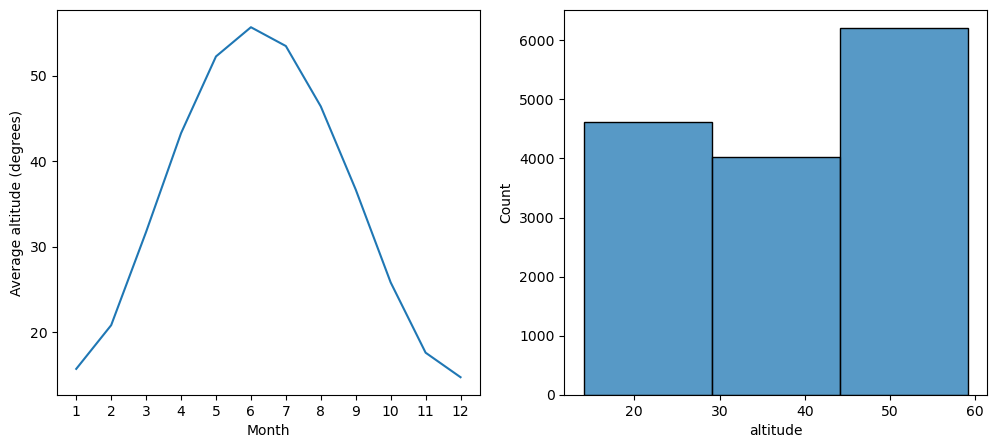

In [4]:
# altitude sense check
fig, ax = plt.subplots(1,2,figsize=(12, 5))

avg_altitude = df_scenes.groupby('month')['altitude'].mean()

# plot line chart of average altitude by month
sns.lineplot(data=avg_altitude, ax=ax[0])

# set ticks and labels
ax[0].set_xticks(range(1, 13))
ax[0].set_xlabel('Month')
ax[0].set_ylabel('Average altitude (degrees)')

# Plot a histogram of the altitude
hist = sns.histplot(data=df_scenes, x='altitude', bins=3, ax=ax[1])

print(df_scenes['altitude'].quantile([0.33, 0.66]))

0.056228956228956226


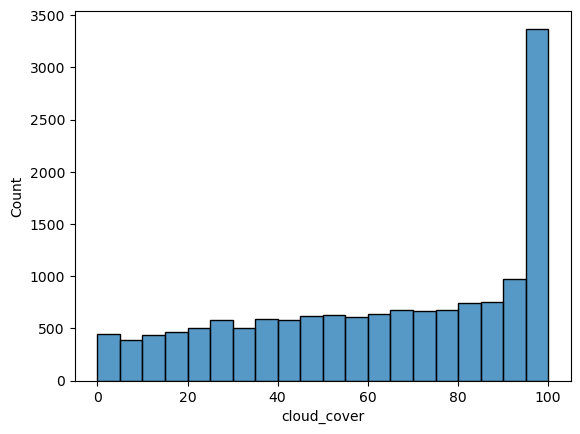

In [5]:
# Histogram of cloud cover
sns.histplot(data=df_scenes, x='cloud_cover', bins=20)

# Percentage of cloud cover below 10%
print(len(df_scenes[df_scenes['cloud_cover'] < 10]) / len(df_scenes))

In [6]:
# Additonal sense check
print(df_scenes['satellite'].value_counts(sort=False))

print(df_scenes[['path','row']].value_counts(sort=False))

print(df_scenes['year'].value_counts(sort=False))

5    6239
4      42
7    4498
8    3558
9     513
Name: satellite, dtype: int64
path  row
205   22     884
      23     924
      24     955
206   21     798
      22     852
      23     915
      24     913
207   21     810
      22     848
      23     906
      24     922
208   21     804
      22     848
      23     893
      24     910
209   21       2
      22     581
      23     606
      24     479
dtype: int64
1984     91
1985    194
1986    168
1987    226
1988    250
1989    271
1990    245
1991    302
1992    259
1993    233
1994    303
1995    299
1996    309
1997    325
1998    326
1999    423
2000    496
2001    502
2002    447
2003    249
2004    274
2005    282
2006    261
2007    233
2008    179
2009    309
2010    246
2011    296
2012    127
2013    393
2014    611
2015    637
2016    629
2017    639
2018    648
2019    644
2020    624
2021    651
2022    927
2023    322
Name: year, dtype: int64


## Select scenes to download

In [7]:
# path, row combinations to filter tiles
path_row = [(205,23),(205,24),
            (206,22),(206,23),(206,24),
            (207,22),(207,23),(207,24),
            (208,22),(208,23),(208,24)]

In [8]:
df_scenes= pd.read_csv('../data/all_scenes_cleaned.csv')

# only tier 1
df_scenes = df_scenes[df_scenes.tier == 1]

# only tile combinations
df_scenes = df_scenes[df_scenes[['path','row']].apply(tuple, axis=1).isin(path_row)]

# before 31 May 2003 for landsat 7 
df_scenes = df_scenes[(df_scenes.satellite != 7) | (df_scenes.date < '2003-05-31')]

# no landsat 4
df_scenes = df_scenes[df_scenes.satellite != 4]

# cloud cover less than 10%
df_scenes = df_scenes[df_scenes.cloud_cover < 10]

df_scenes.to_csv('../data/final_scenes.csv', index=False)
print(len(df_scenes))
df_scenes.head(5)

326


,id,path,row,satellite,cloud_cover,tier,utm_zone,lat,lon,date,time,year,month,altitude,altitude_category,tile
43,LT05_L2SP_206022_19840704_20200918_02_T1,206,22,5,6,1,30,54.51279,-5.90980,1984-07-04,1984-07-04 10:50:49.021500,1984,7,53.493618,high,206_22
89,LT05_L2SP_206024_19841125_20200918_02_T1,206,24,5,5,1,29,51.68211,-7.20095,1984-11-25,1984-11-25 10:52:57.980880,1984,11,15.303771,low,206_24
172,LT05_L2SP_205023_19850529_20200918_02_T1,205,23,5,6,1,30,53.09847,-5.09606,1985-05-29,1985-05-29 10:46:37.112440,1985,5,54.063714,high,205_23
173,LT05_L2SP_205024_19850529_20200918_02_T1,205,24,5,2,1,30,51.69998,-5.74215,1985-05-29,1985-05-29 10:47:00.807440,1985,5,54.943804,high,205_24
177,LT05_L2SP_208022_19850603_20200918_02_T1,208,22,5,3,1,29,54.52100,-9.04258,1985-06-03,1985-06-03 11:04:45.229880,1985,6,53.710770,high,208_22


In [9]:
print(df_scenes[['path','row']].value_counts(sort=False))

# count by year and altitude category
df = df_scenes.groupby(['year', 'altitude_category']).size().reset_index(name='counts')
df.to_clipboard(index=False)

path  row
205   23     40
      24     63
206   22     24
      23     30
      24     33
207   22     22
      23     31
      24     25
208   22     19
      23     19
      24     20
dtype: int64


In [85]:
# Download scenes
from landsatxplore.earthexplorer import EarthExplorer
import os

# Initialize the API
ee = EarthExplorer(username, password)

# Loop through each scene
#for i,ID in enumerate({df_scenes.id}):
for i,ID in enumerate(["LC08_L2SP_207023_20130403_20200913_02_T1"]):

        # Download the scene 
        try: 
            ee.download(ID, output_dir='../data')
            
        # Additional error handling
        except:
            if os.path.isfile('../data/{}.tar'.format(ID)):
                print('{} error but file exists'.format(ID))
            else:
                print('{} error'.format(ID))

        print()

ee.logout()

Download failed with dataset id 1 of 3. Re-trying with the next one.


100%|██████████| 833M/833M [00:35<00:00, 24.5MB/s]  


None of the archived ids succeeded! Update necessary!
LC08_L2SP_207023_20130403_20200913_02_T1 error but file exists



In [82]:
import tarfile

# Extract files from tar archive
for ID in df_scenes.id:
    tar = tarfile.open('../data/{}.tar'.format(ID))
    tar.extractall('../data/{}'.format(ID))
    tar.close()

ReadError: unexpected end of data

# Choose 100 scenes to label

In [10]:
df_scenes = pd.read_csv('../data/final_scenes.csv')

df_scenes.sort_values(by=['cloud_cover','year', 'altitude_category'], inplace=True)

# select first scene for each year and altitude category
df_label = df_scenes.groupby(['year', 'altitude_category']).first().reset_index().dropna(subset=['id'])

# display results
print(len(df_label))
df_label.head()
print(df_label[['path','row']].value_counts(sort=False))

92
path  row
205   23     11
      24     20
206   22      9
      23      6
      24     10
207   22      1
      23     10
      24      7
208   22      6
      23      6
      24      6
dtype: int64


In [12]:
#add 8 scenes 
id = df_label[(df_label['path']==207) & (df_label['row']==22)]["id"]

df_add = df_scenes[(df_scenes['path']==207) & (df_scenes['row']==22) & (df_scenes['id']!=id.values[0])]

# select first 3 scenes for each altitudde category
df_add = df_add.groupby(['altitude_category']).head(3)

# drop maximum cloud cover
df_add = df_add[df_add['cloud_cover']!=df_add['cloud_cover'].max()]

# add to label dataframe
df_label = pd.concat([df_label, df_add])

df_label.sort_values(by=['id'], inplace=True)

df_label.to_csv('../data/label_scenes.csv', index=False)
print(len(df_label))
df_label.head()

100


,year,altitude_category,id,path,row,satellite,cloud_cover,tier,utm_zone,lat,lon,date,time,month,altitude,tile
73,2017,high,LC08_L2SP_205023_20170505_20200904_02_T1,205,23,8,2,1,30,53.10266,-5.02235,2017-05-05,2017-05-05 11:15:45.516137,5,51.383728,205_23
78,2019,high,LC08_L2SP_205023_20190628_20200827_02_T1,205,23,8,9,1,30,53.10258,-5.04996,2019-06-28,2019-06-28 11:16:20.726652,6,57.582579,205_23
81,2020,high,LC08_L2SP_205023_20200529_20200820_02_T1,205,23,8,2,1,30,53.10270,-5.03278,2020-05-29,2020-05-29 11:15:55.184734,5,56.487645,205_23
68,2015,low,LC08_L2SP_205024_20150124_20200910_02_T1,205,24,8,4,1,30,51.69320,-5.72348,2015-01-24,2015-01-24 11:16:47.907172,1,17.108840,205_24
67,2015,high,LC08_L2SP_205024_20150719_20200909_02_T1,205,24,8,5,1,30,51.69345,-5.70362,2015-07-19,2015-07-19 11:16:25.474865,7,56.077386,205_24
